## Install TensorTrade

In [ ]:
# !python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git

## Setup Data Fetching

In [2]:
import pandas as pd
import tensortrade.env.default as default

from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import DQNAgent


%matplotlib inline

In [4]:
cdd = CryptoDataDownload()

# data = cdd.fetch("Bitstamp", "USD", "BTC", "1h")
data = cdd.fetch("Bitstamp", "USD", "BTC", "d")
data.describe()

,unix,open,high,low,close,volume
count,2.353000e+03,2353.000000,2353.000000,2353.000000,2353.000000,2.353000e+03
mean,1.518739e+09,7393.879754,7624.799197,7141.450140,7417.713587,5.161336e+07
std,5.869989e+07,11106.792167,11475.554667,10699.560353,11152.643153,1.036513e+08
min,1.417133e+09,162.000000,212.840000,152.400000,162.000000,0.000000e+00
25%,1.467936e+09,585.250000,594.000000,576.010000,587.570000,8.394920e+03
50%,1.518739e+09,4606.260000,4865.000000,4435.890000,4615.000000,5.085593e+04
75%,1.569542e+09,9175.700000,9366.600000,8961.530000,9177.430000,6.206682e+07
max,1.620346e+09,63605.690000,64895.220000,61998.900000,63564.480000,1.446125e+09


## Create features with the feed module

In [5]:
def rsi(price: Stream[float], period: float) -> Stream[float]:
    r = price.diff()
    upside = r.clamp_min(0).abs()
    downside = r.clamp_max(0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)


def macd(price: Stream[float], fast: float, slow: float, signal: float) -> Stream[float]:
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal


features = []
for c in data.columns[2:]:
    s = Stream.source(list(data[c]), dtype="float").rename(data[c].name)
    features += [s]

cp = Stream.select(features, lambda s: s.name == "close")

features = [
    cp.log().diff().rename("lr"),
    rsi(cp, period=20).rename("rsi"),
    macd(cp, fast=10, slow=50, signal=5).rename("macd")
]

feed = DataFeed(features)

feed.compile()

In [6]:
for i in range(5):
    print(feed.next())

{'lr': nan, 'rsi': nan, 'macd': 0.0}
{'lr': 0.0011686588315482638, 'rsi': 100.0, 'macd': 0.041830065359476976}
{'lr': -0.009012673330848209, 'rsi': 11.005792522381274, 'macd': -0.26086004217491643}
{'lr': 0.013435877162760512, 'rsi': 62.91334126424957, 'macd': 0.08096617913246165}
{'lr': 0.002270208461430556, 'rsi': 66.42394577111436, 'macd': 0.33603410037713494}
/Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return self.op(self.inputs[0].value, self.inputs[1].value)


## Setup Trading Environment

In [7]:
bitstamp = Exchange("bitstamp", service=execute_order)(
    Stream.source(list(data["close"]), dtype="float").rename("USD-BTC")
)

# portfolio = Portfolio(USD, [
#     Wallet(bitstamp, 10000 * USD),
#     Wallet(bitstamp, 0.0001 * BTC)
# ])

cash = Wallet(bitstamp, 10000 * USD)
asset = Wallet(bitstamp, 0.05 * BTC)

portfolio = Portfolio(USD, [
    cash,
    asset
])


renderer_feed = DataFeed([
    Stream.source(list(data["date"])).rename("date"),
    Stream.source(list(data["open"]), dtype="float").rename("open"),
    Stream.source(list(data["high"]), dtype="float").rename("high"),
    Stream.source(list(data["low"]), dtype="float").rename("low"),
    Stream.source(list(data["close"]), dtype="float").rename("close"), 
    Stream.source(list(data["volume"]), dtype="float").rename("volume") 
])


env = default.create(
    portfolio=portfolio,
    #     action_scheme="managed-risk",
#     reward_scheme="risk-adjusted",
#     action_scheme=default.actions.ManagedRiskOrders(),
    action_scheme=default.actions.BSH(cash, asset),
    reward_scheme=default.rewards.SimpleProfit(),
#     action_scheme=default.actions.SimpleOrders(),
#     reward_scheme=default.rewards.SimpleProfit(),
    feed=feed,
    renderer_feed=renderer_feed,
    renderer=default.renderers.PlotlyTradingChart(),
    # renderer="screen-log",
    window_size=20
)

In [8]:
env.observer.feed.next()

{'internal': {'bitstamp:/USD-BTC': 376.28,
  'bitstamp:/USD:/free': 10000.0,
  'bitstamp:/USD:/locked': 0.0,
  'bitstamp:/USD:/total': 10000.0,
  'bitstamp:/BTC:/free': 0.05,
  'bitstamp:/BTC:/locked': 0.0,
  'bitstamp:/BTC:/total': 0.05,
  'bitstamp:/BTC:/worth': 18.814,
  'net_worth': 10018.814},
 'external': {'lr': nan, 'rsi': nan, 'macd': 0.0},
 'renderer': {'date': Timestamp('2014-11-28 00:00:00'),
  'open': 363.59,
  'high': 381.34,
  'low': 360.57,
  'close': 376.28,
  'volume': 8617.15}}

## Setup and Train DQN Agent

In [9]:
agent = DQNAgent(env)

agent.train(n_steps=2000, n_episodes=20, save_path="agents/")

-05-07 3:51:39 PM] Episode: 11/20 Step: 1701/2000
[2021-05-07 3:51:42 PM] Episode: 11/20 Step: 1751/2000
[2021-05-07 3:51:45 PM] Episode: 11/20 Step: 1801/2000
[2021-05-07 3:51:48 PM] Episode: 11/20 Step: 1851/2000
[2021-05-07 3:51:51 PM] Episode: 11/20 Step: 1901/2000
[2021-05-07 3:51:53 PM] Episode: 11/20 Step: 1951/2000
[2021-05-07 3:51:56 PM] Episode: 11/20 Step: 2001/2000
[2021-05-07 3:51:59 PM] Episode: 12/20 Step: 51/2000
[2021-05-07 3:52:03 PM] Episode: 12/20 Step: 101/2000
[2021-05-07 3:52:06 PM] Episode: 12/20 Step: 151/2000
[2021-05-07 3:52:09 PM] Episode: 12/20 Step: 201/2000
[2021-05-07 3:52:13 PM] Episode: 12/20 Step: 251/2000
[2021-05-07 3:52:16 PM] Episode: 12/20 Step: 301/2000
[2021-05-07 3:52:19 PM] Episode: 12/20 Step: 351/2000
[2021-05-07 3:52:22 PM] Episode: 12/20 Step: 401/2000
[2021-05-07 3:52:26 PM] Episode: 12/20 Step: 451/2000
[2021-05-07 3:52:29 PM] Episode: 12/20 Step: 501/2000
[2021-05-07 3:52:32 PM] Episode: 12/20 Step: 551/2000
[2021-05-07 3:52:36 PM] Epi

0.038810071233774564

In [ ]:
# from stable_baselines.common.policies import MlpLnLstmPolicy
# from stable_baselines import PPO2

# model = PPO2
# policy = MlpLnLstmPolicy
# params = { "learning_rate": 1e-5 }

# agent = model(policy, environment, model_kwargs=params)

In [ ]:
# from tensorforce.agents import Agent

# agent_spec = {
#     "type": "ppo_agent",
#     "step_optimizer": {
#         "type": "adam",
#         "learning_rate": 1e-4
#     },
#     "discount": 0.99,
#     "likelihood_ratio_clipping": 0.2,
# }

# network_spec = [
#     dict(type='dense', size=64, activation="tanh"),
#     dict(type='dense', size=32, activation="tanh")
# ]

# agent = Agent.from_spec(spec=agent_spec,
#                         kwargs=dict(network=network_spec,
#                                     states=environment.states,
#                                     actions=environment.actions))

In [11]:
# /Users/yuan/Projects/github/ai-trading/examples/agents/policy_network__fb572bfe-2aad-4fe1-aa2f-f5de548902ff__019.hdf5

agent = DQNAgent(env)
agent.restore(path='agents/policy_network__2f3dd37__20210507_160943.hdf5')

In [12]:

episode_reward = 0
done = False

state  = env.reset()
# while not done:
for _ in range(len(data.index)):
    action = agent.get_action(state, threshold=0)
    next_state, reward, done, info = env.step(action)
    print(info)
    episode_reward += reward
    state = next_state

env.render()

887.52}
{'step': 1868, 'net_worth': 345887.52}
{'step': 1869, 'net_worth': 345887.52}
{'step': 1870, 'net_worth': 345887.52}
{'step': 1871, 'net_worth': 345887.52}
{'step': 1872, 'net_worth': 345887.52}
{'step': 1873, 'net_worth': 345887.52}
{'step': 1874, 'net_worth': 345887.52}
{'step': 1875, 'net_worth': 345887.52}
{'step': 1876, 'net_worth': 345887.52}
{'step': 1877, 'net_worth': 345466.4507048107}
{'step': 1878, 'net_worth': 344430.05}
{'step': 1879, 'net_worth': 344430.05}
{'step': 1880, 'net_worth': 344430.05}
{'step': 1881, 'net_worth': 344430.05}
{'step': 1882, 'net_worth': 344430.05}
{'step': 1883, 'net_worth': 344430.05}
{'step': 1884, 'net_worth': 344430.05}
{'step': 1885, 'net_worth': 354156.0716140016}
{'step': 1886, 'net_worth': 353093.6}
{'step': 1887, 'net_worth': 353093.6}
{'step': 1888, 'net_worth': 347884.0600284526}
{'step': 1889, 'net_worth': 346840.41}
{'step': 1890, 'net_worth': 346840.41}
{'step': 1891, 'net_worth': 346840.41}
{'step': 1892, 'net_worth': 346840

FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

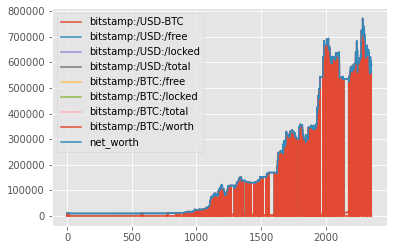

In [13]:
performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')

# copy performance data to clipboard for analysis using Number
# performance.to_clipboard(index=True)
performance.to_csv('BTC_USD_Performance.csv')
performance.plot()

from pandasgui import show
gui = show(performance)